In [43]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *

# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

In [3]:
path = Config().data_path()/'rossmann'
train_df = pd.read_pickle(path/'train_clean')

In [4]:
train_df.head().T

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [5]:
n = len(train_df); n

844338

### Experimenting with a sample

In [6]:
idx = train_df.sample(n=2000, random_state=42).index.sort_values()
small_train_df = train_df.iloc[idx[:1000]]
small_test_df = train_df.iloc[idx[1000:]]
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]

In [7]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
893,896,5,NaN,170.0,61,8763
1071,1074,5,"Jan,Apr,Jul,Oct",3330.0,55,6789
2047,937,4,"Jan,Apr,Jul,Oct",2810.0,56,7722
2403,178,3,NaN,1710.0,55,10766
2685,461,3,"Jan,Apr,Jul,Oct",1790.0,73,6176


In [8]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
433256,182,3,"Mar,Jun,Sept,Dec",1390.0,63,4907
433387,313,3,NaN,14160.0,71,6816
434021,948,3,NaN,1430.0,56,6566
434677,492,2,"Jan,Apr,Jul,Oct",1740.0,61,9110
434725,540,2,"Jan,Apr,Jul,Oct",810.0,61,6518


<font color='red'>Learn to use `Categorify`:</font>
``` python
from fastai.tabular.transform import Categorify
```
> notice how it is called upon the data:
>> - after initialized, it is called upon training df first, and then upon the test/valid df

In [9]:
categorify = Categorify(small_cat_vars, small_cont_vars)
categorify(small_train_df)
categorify(small_test_df, test=True)

- when `Categorify` a training portion, we need to pay attention to the scenario where not all categories in test portion are seen in training.
> so these categories become `NaN` in the test_df

In [10]:
182 in categorify.categories['Store']

False

In [10]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
433256,NaN,3,"Mar,Jun,Sept,Dec",1390.0,63,4907
433387,313.0,3,NaN,14160.0,71,6816
434021,NaN,3,NaN,1430.0,56,6566
434677,492.0,2,"Jan,Apr,Jul,Oct",1740.0,61,9110
434725,540.0,2,"Jan,Apr,Jul,Oct",810.0,61,6518


In [11]:
small_train_df.PromoInterval.cat.categories

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [12]:
small_train_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
893,896,5,NaN,170.0,61,8763
1071,1074,5,"Jan,Apr,Jul,Oct",3330.0,55,6789
2047,937,4,"Jan,Apr,Jul,Oct",2810.0,56,7722
2403,178,3,NaN,1710.0,55,10766
2685,461,3,"Jan,Apr,Jul,Oct",1790.0,73,6176


- missing values `NaN` in the df become `-1`; as embedding doesn't work with negative values, later in trainining all category code will ++1

In [13]:
small_train_df['PromoInterval'].cat.codes[:5]

893    -1
1071    1
2047    1
2403   -1
2685    1
dtype: int8

<font color='red'>Learn to use `FillMissing`:</font>
```python
from fastai.tabular.transform import FillMissing
```
There are 3 filling strategies:
  1. fill median (default)
  2. fill constant
  3. fill the most probable value

In [14]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [15]:
small_train_df[small_train_df['CompetitionDistance_na'] == True]

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
202217,622,1,NaN,2410.0,94,8451,True
275513,291,5,NaN,2410.0,76,7571,True


<font color='red'>Learn to use `Normalize`:</font>
``` python
from fastai.tabular.transform import Normalize
```

### Preparing full data set

In [16]:
train_df = pd.read_pickle(path/'train_clean')
test_df = pd.read_pickle(path/'test_clean')

In [17]:
len(train_df),len(test_df)

(844338, 41088)

In [18]:
procs=[FillMissing, Categorify, Normalize]

In [19]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [23]:
dep_var = 'Sales'  # dep_var means dependent variable, a.k.a. the learning target
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()  # `df` will be split for training and validation

In [25]:
train_df['Date'].min(), train_df['Date'].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [21]:
test_df['Date'].min(), test_df['Date'].max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

> we want to use approximately the same number of records for validation set as in test set

> and at the same time we don't want to exclude any records with the same timestamp

In [48]:
# this cell does the same as the next cell, but probably more clear
_date = train_df.loc[len(test_df), 'Date']
train_df.query('Date == @_date').index.max()

41395

In [49]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [50]:
valid_idx = range(cut)

In [51]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [54]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)  # use FloatList to indicating a regression practice
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))  # test set is added
                .databunch())

In [53]:
doc(FloatList)

class FloatList [source] FloatList ( items : Iterator [ T_co ], log : bool = False , classes : Collection [ T_co ]= None , ** kwargs ) :: ItemList 
 
 ItemList suitable for storing the floats in items for regression. Will add a log if this flag is True . 
 Show in docs

## Model

### what is the range of value for "target" that we are trying to predict? - specify `y_range`

In [55]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [56]:
learn = tabular_learner(data, 
                        layers=[1000,500], 
                        ps=[0.001,0.01],   # probabilities for dropout for fully connected layers
                        emb_drop=0.04,     # probabilities for dropout for embedding layers
                        y_range=y_range, metrics=exp_rmspe)

In [57]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [58]:
len(data.train_ds.cont_names)

16

In [59]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


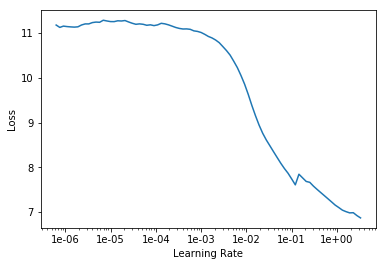

In [60]:
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
1,0.022998,0.022899,0.157327,02:03
2,0.022732,0.016539,0.129704,02:04
3,0.016730,0.014491,0.119255,02:05
4,0.011973,0.013913,0.111285,02:04
5,0.011340,0.011498,0.103306,02:07


In [77]:
!ls -lh /home/jupyter/.fastai/data/rossmann/models

total 13M
-rw-r--r-- 1 jupyter jupyter 9.6M Apr  1 04:34 1.pth
-rw-r--r-- 1 jupyter jupyter 3.2M Apr  1 04:21 tmp.pth


In [62]:
learn.save('1')

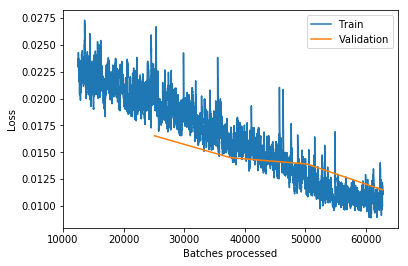

In [78]:
learn.recorder.plot_losses(last=-1)

In [79]:
learn.load('1');

In [80]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
1,0.011202,0.012984,0.108317,02:03
2,0.011643,0.012743,0.112405,02:06
3,0.011406,0.016317,0.113728,02:05
4,0.009034,0.022027,0.108258,02:07
5,0.008526,0.015151,0.111539,02:05


In [81]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
1,0.011084,0.013352,0.112836,02:04
2,0.011475,0.017505,0.138606,02:05
3,0.009940,0.014216,0.116940,02:06
4,0.010251,0.016459,0.115027,02:04
5,0.008501,0.019964,0.120384,02:06


(10th place in the competition was 0.108)

In [83]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)

In [95]:
np.exp(test_preds[0].data.numpy().T[0])

array([ 4502.1426,  7048.6133,  8940.192 ,  7891.7915, ...,  7586.198 ,  6167.012 , 23663.174 ,  7890.106 ],
      dtype=float32)

In [115]:
data.show_batch()

Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance_na,CloudCover_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,target
853,2,2014,1,7,False,0,0,a,a,#na#,1900,1900,BW,2,#na#,4.0,2.0,0.0,2.0,0.0,3.0,False,False,1.1007,-0.2275,-0.2366,-0.0861,-1.4966,-0.2645,0.0207,-1.2877,-1.1514,0.2552,-0.0466,-1.1325,-1.1752,-1.9262,1.1119,-0.4796,9.6222515
659,6,2013,3,30,False,12,0,d,a,#na#,2012,1900,HE,13,#na#,0.0,5.0,1.0,1.0,5.0,5.0,False,False,-0.4948,-0.9491,-1.0824,-1.0324,-0.8405,-0.8012,-0.8450,-0.1780,0.1902,0.2552,-0.3185,-0.9164,-1.1752,1.1232,-0.8994,-0.4796,8.4004345
29,3,2015,2,25,False,0,0,d,c,#na#,1900,1900,NW,9,Rain,2.0,2.0,0.0,0.0,0.0,0.0,False,False,-0.4205,-0.7085,-0.8004,-0.7169,0.8653,0.8088,0.7336,0.3768,0.3579,0.2552,0.8597,0.5969,0.5308,0.0451,-0.8994,-0.4796,8.697846
819,5,2014,12,19,False,2,0,a,c,#na#,2014,1900,SH,51,Rain,1.0,5.0,1.0,0.0,4.0,0.0,False,False,-0.6063,-0.3478,-0.2366,-0.2438,0.4717,0.8854,0.8864,0.7097,1.8672,-0.3604,0.2253,1.4616,1.2258,1.0000,1.1119,-0.4796,9.053335
280,4,2013,11,28,False,2,0,d,c,"Mar,Jun,Sept,Dec",2013,2014,BW,48,Rain-Snow,3.0,1.0,0.0,0.0,0.0,0.0,False,False,1.6902,-1.5504,-1.6462,-1.6632,0.8653,0.8088,0.9373,-1.6206,-1.4869,0.8708,0.5878,1.1373,-0.3538,0.3531,-0.8994,-0.4796,8.641709
